# CLAY v0 - Quality of reconstruction by the model 

In [1]:
import sys

sys.path.append("../")

In [3]:
from pathlib import Path

import einops
import matplotlib.pyplot as plt
import pandas as pd
import torch
from einops import rearrange

from src.datamodule import ClayDataModule, ClayDataset
from src.model_clay import CLAYModule

In [4]:
DATA_DIR = "../data/02"  # data directory for all chips
CKPT_PATH = "../checkpoints/v0/mae_epoch-24_val-loss-0.46.ckpt"  # path of best model checkpoint for Clay v0

## Load Model & DataModule

In [5]:
# Load the model & set in eval mode
model = CLAYModule.load_from_checkpoint(CKPT_PATH, mask_ratio=0.7)
model.eval();

In [6]:
data_dir = Path(DATA_DIR)

# Load the Clay DataModule
ds = ClayDataset(chips_path=list(data_dir.glob("**/*.tif")))
dm = ClayDataModule(data_dir=str(data_dir), batch_size=8)
dm.setup(stage="fit")

# Load the train DataLoader
trn_dl = iter(dm.train_dataloader())

Total number of chips: 414


In [7]:
# Load the first batch of chips
batch = next(trn_dl)
batch.keys()

dict_keys(['pixels', 'bbox', 'epsg', 'date', 'latlon', 'timestep', 'source_url'])

In [8]:
batch["pixels"].shape, batch["latlon"].shape, batch["timestep"].shape

(torch.Size([8, 13, 512, 512]), torch.Size([8, 2]), torch.Size([8, 3]))

Each batch has chips of shape `13 x 512 x 512`, normalized `lat` & `lon` coords & normalized timestep information as `year`, `month` & `day`.

In [9]:
# Save a copy of batch to visualize later
_batch = batch["pixels"].detach().clone().cpu().numpy()

## Pass data through the model

In [10]:
# Pass the pixels through the encoder & decoder of CLAY
with torch.no_grad():
    # Move data from to the device of model
    batch["pixels"] = batch["pixels"].to(model.device)
    batch["timestep"] = batch["timestep"].to(model.device)
    batch["latlon"] = batch["latlon"].to(model.device)

    # Pass pixels, latlon, timestep through the encoder to create encoded patches
    (
        unmasked_patches,
        unmasked_indices,
        masked_indices,
        masked_matrix,
    ) = model.model.encoder(batch)

    # Pass the unmasked_patches through the decoder to reconstruct the pixel space
    pixels = model.model.decoder(unmasked_patches, unmasked_indices, masked_indices)

In [11]:
(
    unmasked_patches.shape,
    unmasked_indices.shape,
    masked_indices.shape,
    masked_matrix.shape,
)

(torch.Size([8, 463, 768]),
 torch.Size([8, 461]),
 torch.Size([8, 1075]),
 torch.Size([8, 6, 256]))

In [12]:
# Reconstructed chips from 70% masked inputs to the model
pixels.shape

torch.Size([8, 13, 256, 1024])

In [13]:
# Rearrange the pixels into chips of size `13 x 512 x 512`
pixels = rearrange(pixels, "b c (h w) (p1 p2) -> b c (h p1) (w p2)", h=16, p1=32)
pixels.shape

torch.Size([8, 13, 512, 512])

## Plot the pixel reconstructions from the CLAY model

In [14]:
def plot_pixel_reconstruction():
    fig, axes = plt.subplots(16, 13, figsize=(20, 20))

    for j in range(8):
        inp = _batch[j]
        out = pixels[j].detach().cpu().numpy()
        j *= 2
        for i in range(13):
            axes[j, i].imshow(inp[i], cmap="viridis")
            axes[(j + 1), i].imshow(out[i], cmap="viridis")
            axes[j, i].set_axis_off()
            axes[(j + 1), i].set_axis_off()

    # Set column labels
    cols = [
        "Blue",
        "Green",
        "Red",
        "RedEdge",
        "RedEdge",
        "RedEdge",
        "NIR",
        "RedEdge",
        "SWIR",
        "SWIR",
        "VV",
        "VH",
        "DEM",
    ]
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)

    plt.tight_layout()

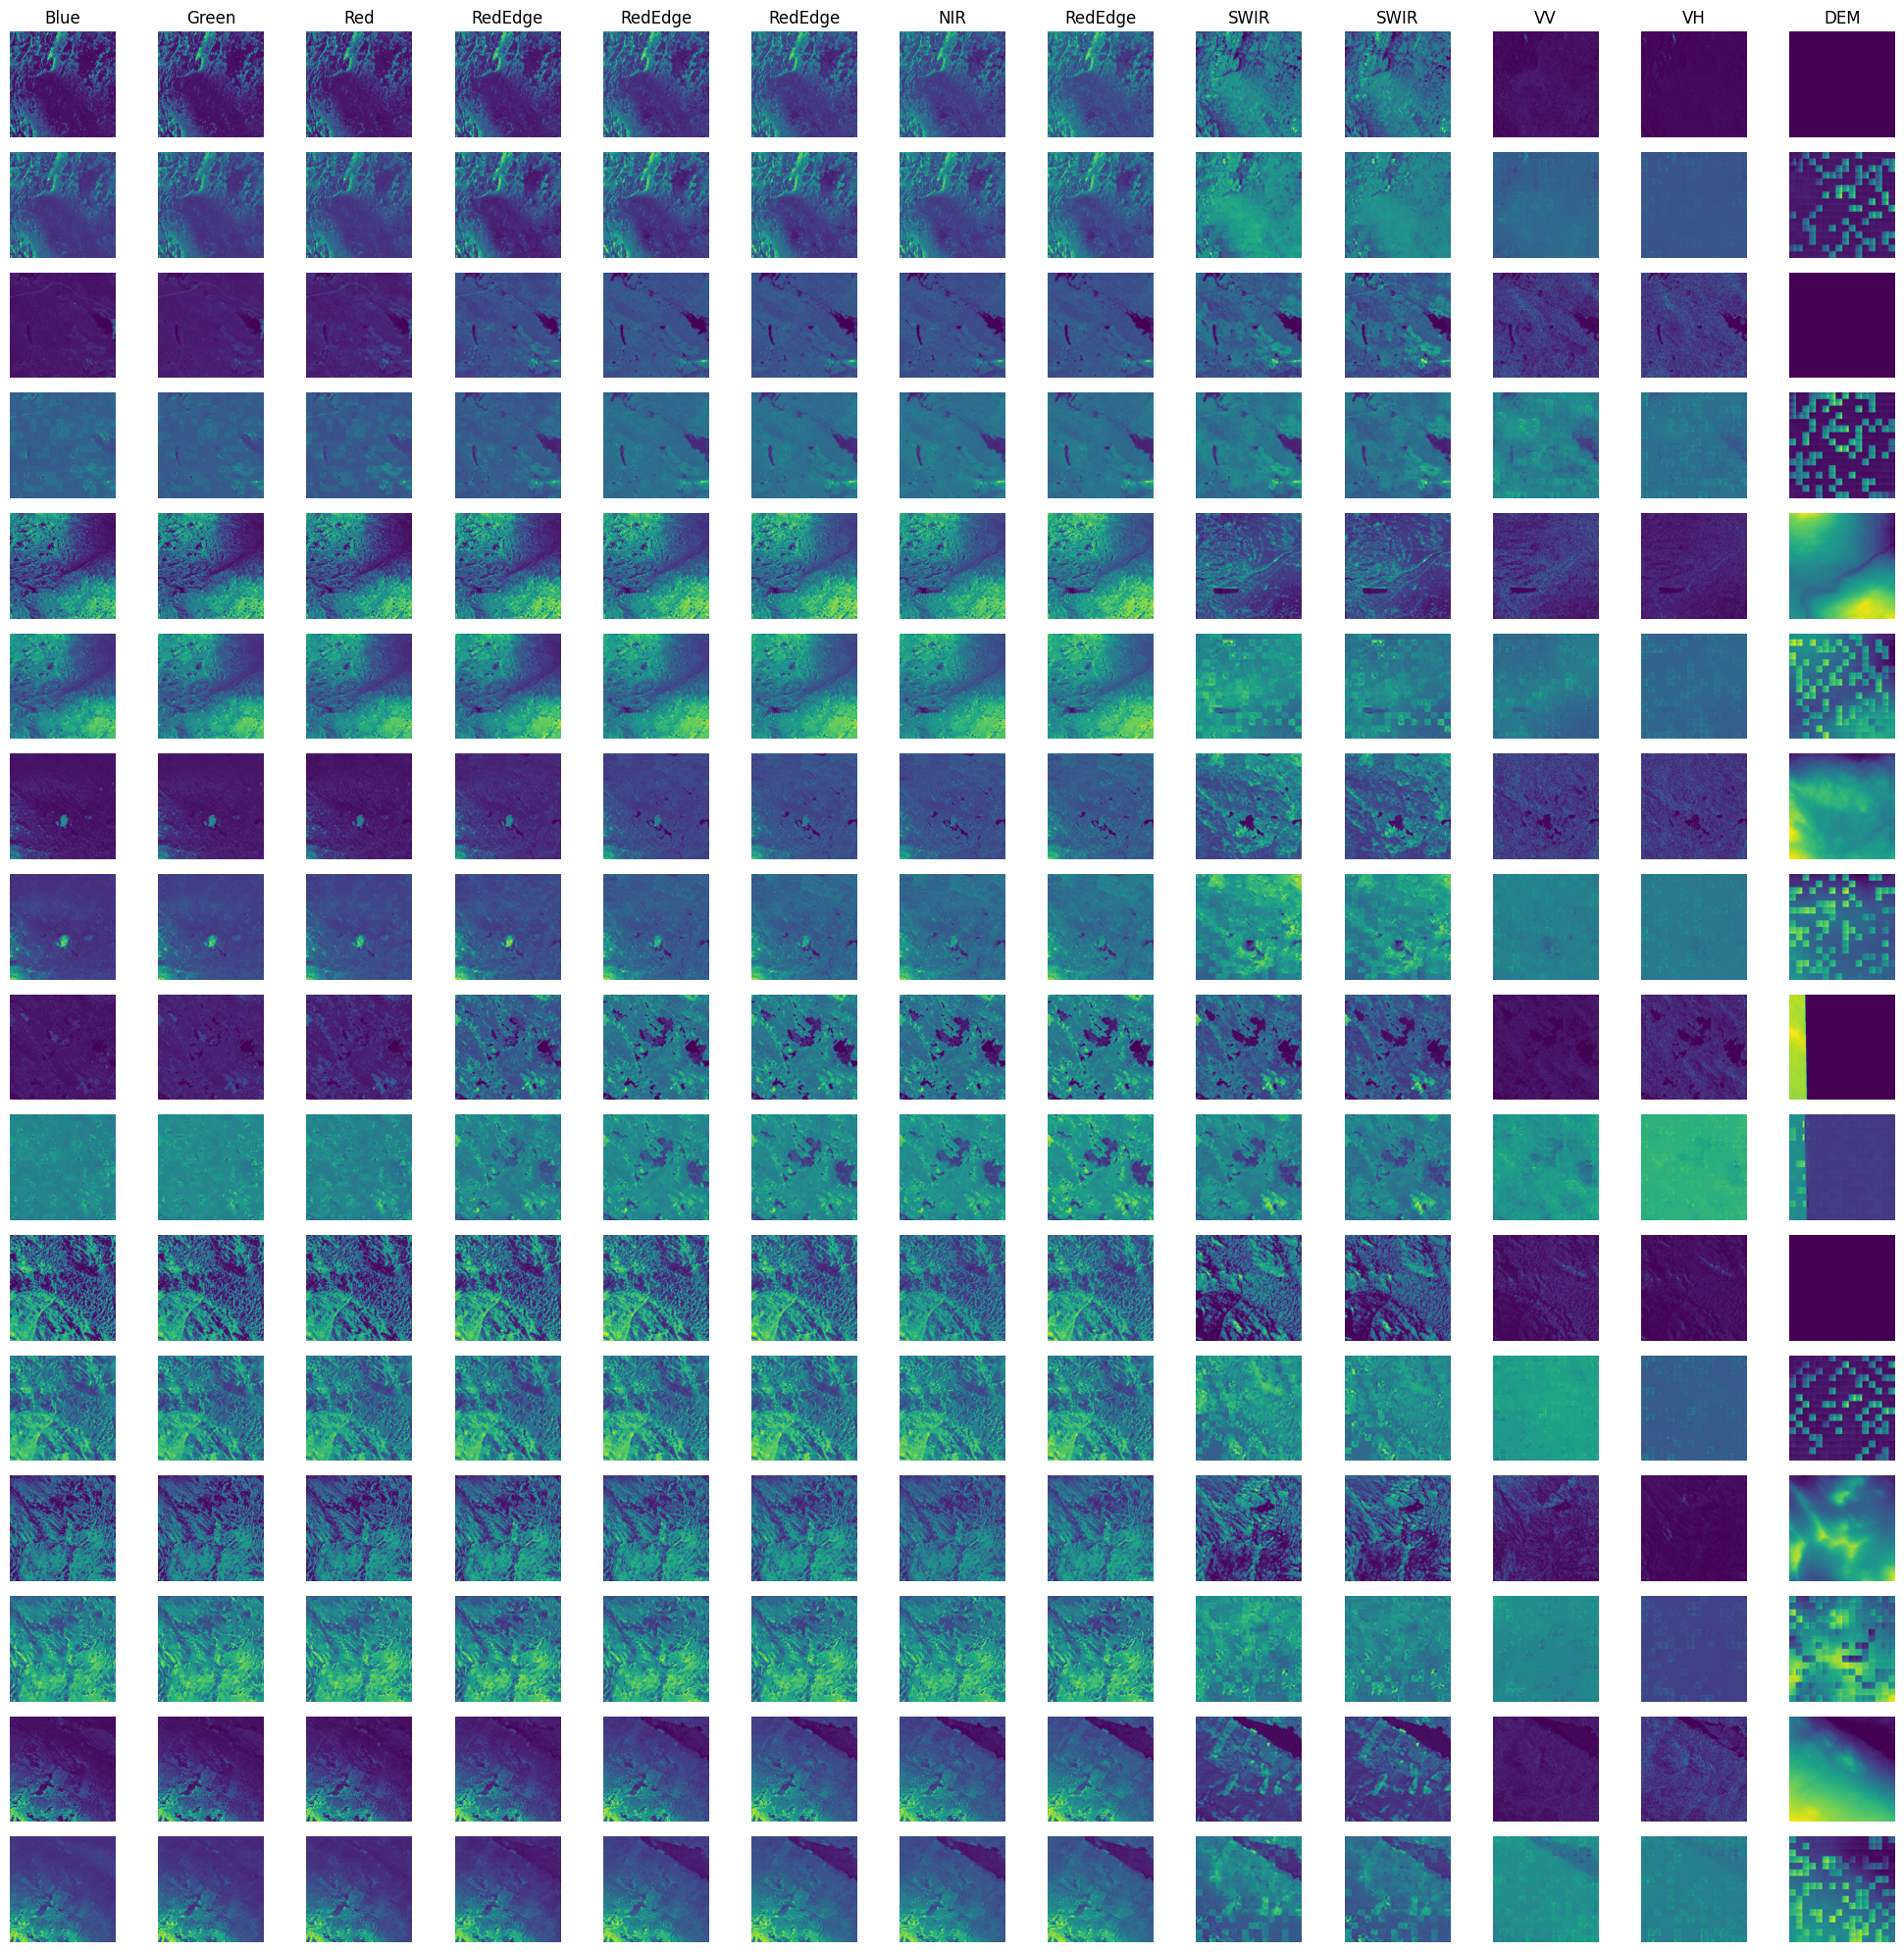

In [15]:
plot_pixel_reconstruction()

> In the figure above, each chip in the batch of eight is represented by two rows: the first row shows the actual image and the second row displays its prediction.

## Verify quality of reconstruction

In [16]:
order = 3  # pick a chip from the batch of size 8
band = 1  # pick a band from 13
mask_order = 0  # represents the group each band falls under, for bands 0-2: mask_order=0, 3,4,5,7: mask_order=1, 6: mask_order=2, 8,9: mask_order=3, 10,11: masked_order=4, 12: mask_order=5

In [17]:
# Select one chip from the batch of inputs & reconstructed pixels
chip = batch["pixels"][order].detach().cpu().numpy()
pred_chip = pixels[order].detach().cpu().numpy()

In [18]:
# Masked matrix stores the position information of masked & unmasked patches of the input
mask = masked_matrix[order]
mask = rearrange(mask[mask_order], "(h w) -> h w", h=16).detach().cpu().numpy()

In [19]:
pd.DataFrame(mask).style.format("{:.1f}").background_gradient(cmap="bwr")

> `1` represents masked patch position & `0` represents unmasked patch position 

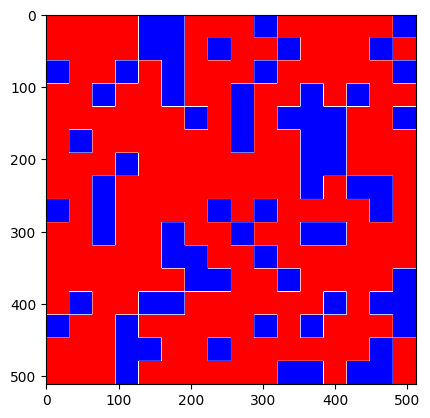

In [20]:
# Scale the mask matrix to size `512 x 512`
upmask = einops.repeat(
    mask, "h w -> (h repeat_h) (w repeat_w)", repeat_h=32, repeat_w=32
)
plt.imshow(upmask, cmap="bwr")

> `Red`: Masked patches & `Blue`: Unmasked Patches

### Plot the quality of reconstruction

In [21]:
# Input to the CLAY model
masked_chip = chip[band] * (1 - upmask)

# Reconstruction from the CLAY model
recreated_chip = pred_chip[band] * upmask
recreated_chip_with_unmasked_patches = masked_chip + recreated_chip

Text(0.5, 1.0, 'Original Input')

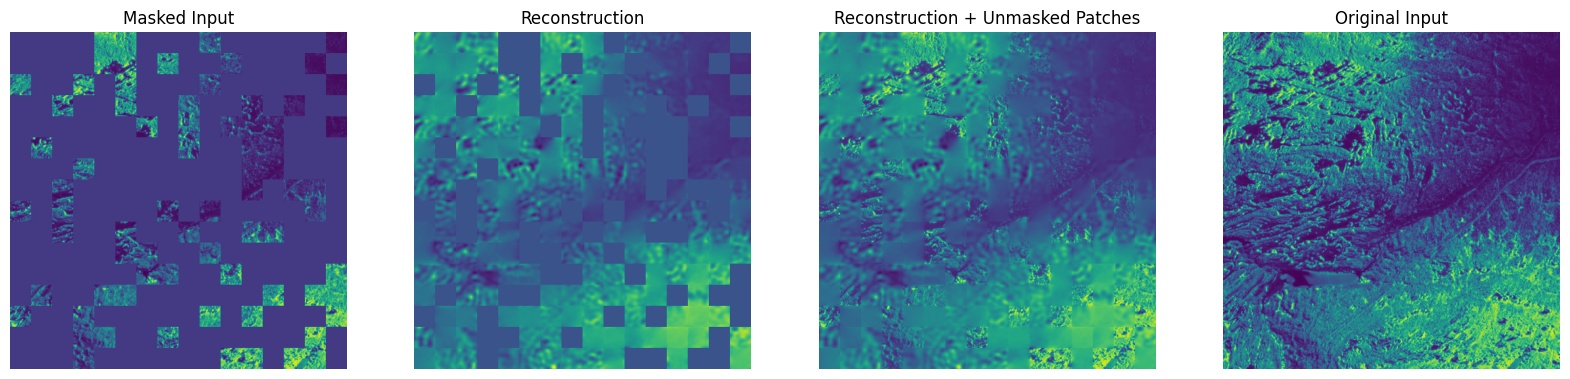

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax in axes:
    ax.set_axis_off()

axes[0].imshow(masked_chip)
axes[0].set_title("Masked Input")

axes[1].imshow(recreated_chip)
axes[1].set_title("Reconstruction")

axes[2].imshow(recreated_chip_with_unmasked_patches)
axes[2].set_title("Reconstruction + Unmasked Patches")

axes[3].imshow(chip[band])
axes[3].set_title("Original Input")